**BELT EXAM**:

**STUDENT NAME:** Mwebaze Junior

In [435]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [436]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [437]:
file_name ='/content/drive/MyDrive/Week2_data/Machine Learning Data Sets/Belt2_C_occupancy_v2_final.csv'
df = pd.read_csv(file_name)
df.head()

,Temperature,Humidity,CO2,IsWeekend,DayOfMonth,Occupancy
0,22.245,Med,Med,Weekday,5,1
1,21.39,High,High,weekday,9,1
2,19_35666667,NaN,Low,Weekday,9,0
3,22.1,NaN,Low,Weekend,7,0
4,21.39,NaN,High,weekday,9,0


In [438]:
#handling data inconsistences in the Temperature column by replacing '_'
df['Temperature'] = df['Temperature'].str.replace('_', '.')

In [439]:
df.head()

,Temperature,Humidity,CO2,IsWeekend,DayOfMonth,Occupancy
0,22.245,Med,Med,Weekday,5,1
1,21.39,High,High,weekday,9,1
2,19.35666667,NaN,Low,Weekday,9,0
3,22.1,NaN,Low,Weekend,7,0
4,21.39,NaN,High,weekday,9,0


In [440]:
df['Humidity'].value_counts()

Humidity
Low       432
Med       399
High      349
Hi         10
medium      9
low         9
Name: count, dtype: int64

In [441]:
df['Humidity']=df['Humidity'].replace({'Hi':'High','low':'Low','medium':'Med'})
df['Humidity'].value_counts()

Humidity
Low     441
Med     408
High    359
Name: count, dtype: int64

In [442]:
df['Temperature'] = df['Temperature'].astype(float)

In [443]:
df.dtypes

Temperature    float64
Humidity        object
CO2             object
IsWeekend       object
DayOfMonth       int64
Occupancy        int64
dtype: object

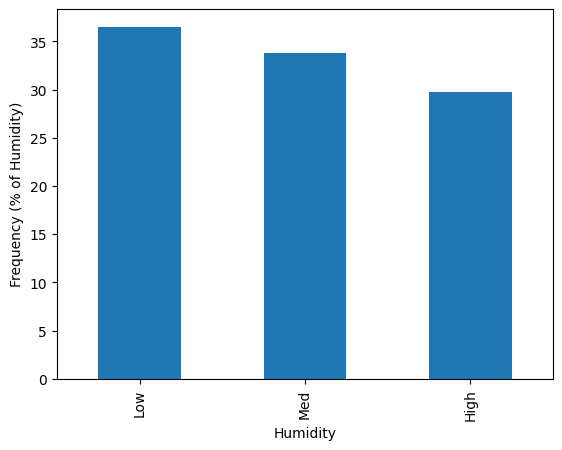

In [444]:
# Plot value counts as a bar graph
val_counts = df['Humidity'].value_counts()
val_counts_norm = df['Humidity'].value_counts(normalize=True) * 100
ax = val_counts_norm.plot(kind='bar')
ax.set_ylabel("Frequency (% of Humidity)");
ax.set_xlabel("Humidity");

There is a Low humidity compared to Med and high


In [445]:
# split in to train and test
target = 'Occupancy'
X = df.drop(columns=target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [446]:
X_train.dtypes

Temperature    float64
Humidity        object
CO2             object
IsWeekend       object
DayOfMonth       int64
dtype: object

<Axes: >

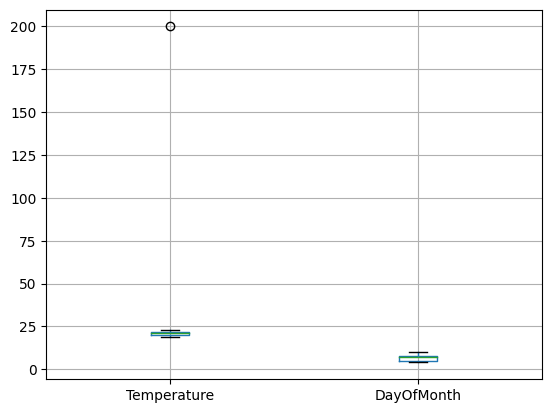

In [447]:
X_train.boxplot()

the plot above shows that we have an outlier in the temperature column

In [448]:
def replace_outliers_with_median(X_train, col):
    # Calculate the median of the specified column
    median = X_train[col].median()

    # Calculate the interquartile range (IQR) to define the threshold for outliers
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the threshold for outliers (commonly 1.5 times the IQR)
    threshold = 1.5 * IQR

    # Identify outliers based on the threshold
    outliers = (X_train[col] < Q1 - threshold) | (X_train[col] > Q3 + threshold)

    # Replace outliers with median
    X_train.loc[outliers, col] = median

# Example usage:
# Specify the column with outliers
outlier_column = 'Temperature'

# Replace outliers with median for the specified column
replace_outliers_with_median(X_train, outlier_column)


In [449]:
def replace_outliers_with_median(X_test, col):
    # Calculate the median of the specified column
    median = X_test[col].median()

    # Calculate the interquartile range (IQR) to define the threshold for outliers
    Q1 = X_test[col].quantile(0.25)
    Q3 = X_test[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the threshold for outliers )
    threshold = 1.5 * IQR

    # Identify outliers based on the threshold
    outliers = (X_test[col] < Q1 - threshold) | (X_test[col] > Q3 + threshold)

    # Replace outliers with median
    X_test.loc[outliers, col] = median

# Example usage:
# Specify the column with outliers
outlier_column = 'Temperature'

# Replace outliers with median for the specified column
replace_outliers_with_median(X_test, outlier_column)


<Axes: >

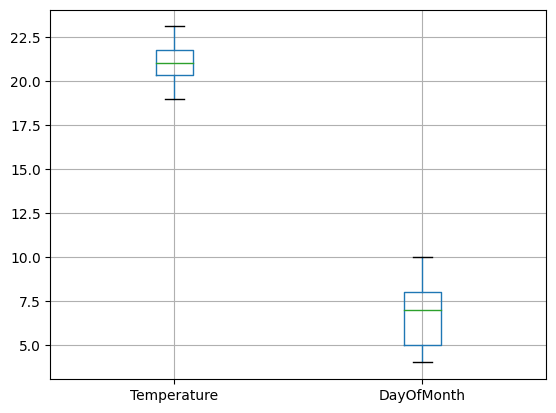

In [450]:
X_test.boxplot()

In [451]:
# Check for null values in numeric columns of trainingset
X_train.isna().sum()

Temperature      0
Humidity       443
CO2              0
IsWeekend        0
DayOfMonth       0
dtype: int64

In [452]:
# Define numeric and categorical columns
numeric_columns = X_train.select_dtypes(include=['float', 'int'])
categorical_columns = X_train.select_dtypes(include='object')

# Imputation for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
numeric_imputed = numeric_imputer.fit_transform(numeric_columns)
# Assign imputed values back to the DataFrame
X_train[numeric_columns.columns] = numeric_imputed

# Imputation for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputed = categorical_imputer.fit_transform(categorical_columns)
# Assign imputed values back to the DataFrame
X_train[categorical_columns.columns] = categorical_imputed

numeric_imputed_df = pd.DataFrame(numeric_imputed, columns=numeric_columns.columns)
categorical_imputed_df = pd.DataFrame(categorical_imputed, columns=categorical_columns.columns)

# Concatenate numeric and categorical imputed DataFrames
imputed_data = pd.concat([numeric_imputed_df, categorical_imputed_df], axis=1)
X_train = imputed_data

In [453]:
# Define numeric and categorical columns
numeric_columns = X_test.select_dtypes(include=['float', 'int'])
categorical_columns = X_test.select_dtypes(include='object')

# Imputation for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
numeric_imputed = numeric_imputer.fit_transform(numeric_columns)
# Assign imputed values back to the DataFrame
X_test[numeric_columns.columns] = numeric_imputed

# Imputation for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputed = categorical_imputer.fit_transform(categorical_columns)
# Assign imputed values back to the DataFrame
X_test[categorical_columns.columns] = categorical_imputed

numeric_imputed_df = pd.DataFrame(numeric_imputed, columns=numeric_columns.columns)
categorical_imputed_df = pd.DataFrame(categorical_imputed, columns=categorical_columns.columns)

# Concatenate numeric and categorical imputed DataFrames
imputed_data = pd.concat([numeric_imputed_df, categorical_imputed_df], axis=1)
X_test = imputed_data

In [454]:
# Check for null values in numeric columns of trainingset
X_test.isna().sum()

Temperature    0
DayOfMonth     0
Humidity       0
CO2            0
IsWeekend      0
dtype: int64

In [455]:
# Initialize LabelEncoder
labelencoder = LabelEncoder()

X_train['Humidity'] = labelencoder.fit_transform(X_train['Humidity'])

X_train['CO2'] = labelencoder.fit_transform(X_train['CO2'])

X_train['IsWeekend'] = labelencoder.fit_transform(X_train['IsWeekend'])

In [456]:
# Initialize LabelEncoder
labelencoder = LabelEncoder()
X_test['Humidity'] = labelencoder.fit_transform(X_test['Humidity'])

X_test['CO2'] = labelencoder.fit_transform(X_test['CO2'])

X_test['IsWeekend'] = labelencoder.fit_transform(X_test['IsWeekend'])

In [457]:
print(X_test)

     Temperature  DayOfMonth  Humidity  CO2  IsWeekend
0      20.865000         6.0         1    2          0
1      21.533333         6.0         1    2          2
2      21.323333         9.0         0    0          2
3      21.100000         7.0         1    1          1
4      22.856667         7.0         1    1          1
..           ...         ...       ...  ...        ...
347    21.675000         6.0         1    2          2
348    22.426667         5.0         0    2          0
349    21.200000         7.0         1    1          1
350    20.700000         6.0         1    1          0
351    22.340000         4.0         1    2          2

[352 rows x 5 columns]


In [458]:
print(X_train)

      Temperature  DayOfMonth  Humidity  CO2  IsWeekend
0       20.290000         6.0         1    1          2
1       19.445000         9.0         1    1          0
2       20.000000         9.0         1    2          0
3       22.050000         5.0         2    2          0
4       23.075000         7.0         1    1          1
...           ...         ...       ...  ...        ...
1401    20.700000         9.0         1    2          2
1402    21.525000         9.0         0    0          0
1403    20.823333         9.0         1    2          0
1404    21.890000         9.0         0    0          0
1405    21.100000         6.0         1    2          2

[1406 rows x 5 columns]


In [459]:
# Instantiate the preprocessor/ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(), categorical_columns)])
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                       Temperature  DayOfMonth
1125    20.865000           6
1030    21.533333           6
1450    21.323333           9
1494    21.100000           7
344     22.856667           7
...           ...         ...
494     21.675000           6
1050    22.426667           5
1542    21.200000           7
1652    20.700000           6
381     22.340000           4

[352 rows x 2 columns]),
                                ('cat', OneHotEncoder(),
                                      Humidity   CO2 IsWeekend
1125      Low   Med   Weekday
1030      NaN   Med   weekday
1450     High  High   weekday
1494      Low   Low   Weekend
344       Low   Low   Weekend
...       ...   ...       ...
494       Low   Med   weekday
1050     High   Med   Weekday
1542      Low   Low   Weekend
1652      NaN   Low   Weekday
381       NaN   Med   weekday

[352 rows x 3 columns])])

In [460]:
model = RandomForestClassifier(random_state=42)

In [461]:
# Define pipeline with preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                        Temperature  DayOfMonth
1125    20.865000           6
1030    21.533333           6
1450    21.323333           9
1494    21.100000           7
344     22.856667           7
...           ...         ...
494     21.675000           6
1050    22.426667           5
1542    21.200000           7
1652    20.700000           6
381     22.340000           4

[352 rows x 2 columns]),
                                                 ('cat', OneHotEncoder(),
                                                       Humidity   CO2 IsWeekend
1125      Low   Med   Weekday
1030      NaN   Med   weekday
1450     High  High   weekday
1494      Low   Low   Weekend
344       Low   Low   Weekend
...       ...   ...       ...
494       Low   Med   weekday
1050     High   Med   Weekday
1542      Low   Low   Weekend
1652      NaN   Low   Weekday
381       NaN   Med   weekday

[352 rows x 3 columns])])),
                ('model', RandomForestClassifier())])

In [462]:
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [463]:
#make predictions
pred = model.predict(X_test)

In [464]:
# Obtain predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculate classification accuracy
train_score = accuracy_score(y_train, train_preds)
test_score = accuracy_score(y_test, test_preds)

In [465]:
print (f'The training accuracy is {train_score:.3f}.')
print (f'The testing accuracy is {test_score:.3f}.')

The training accuracy is 0.930.
The testing accuracy is 0.722.


In [466]:
# Instantiate and fit BaggingClassifier
bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)

# Obtain predictions
train_preds = bag_clf.predict(X_train)
test_preds = bag_clf.predict(X_test)

# Calculate classification accuracy
train_score = accuracy_score(y_train, train_preds)
test_score = accuracy_score(y_test, test_preds)
print (f'The training accuracy is {train_score:.3f}.')
print (f'The testing accuracy is {test_score:.3f}.')


The training accuracy is 0.925.
The testing accuracy is 0.739.


the from result above, i decide to choose the RandomForestClassifier having an accuracy of 0.93 against the test of 0.722